In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata
import dataload as epi
import scib_metrics
from scib_metrics.benchmark import Benchmarker
import scvi
import importlib
import epipack as epk

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be remov

### Dataload

In [2]:
peak_1 = sc.read_h5ad("../../data/pbmc_batch/pbmc_5k_nextgem/peak_1.h5ad")
peak_2 = sc.read_h5ad("../../data/pbmc_batch/pbmc_10k_nextgem/peak_2.h5ad")
peak_3 = sc.read_h5ad("../../data/pbmc_batch/pbmc_10k_chromiumX/peak_3.h5ad")
peak_4 = sc.read_h5ad("../../data/pbmc_batch/pbmc_10k_Chromium_Controller/peak_4.h5ad")
peak_5 = sc.read_h5ad("../../data/pbmc_batch/pbmc_multiome/peak_6.h5ad")

In [3]:
genescore_mtx = sc.read_h5ad("../../data/pbmc_batch/pbmc_5b_genemtx.h5ad")

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [4]:
merge_peak = sc.read_h5ad("../../data/pbmc_batch/pbmc_large_batch/pbmc_large_merge.h5ad")

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [6]:
merge_peak.obs['dataset'] = genescore_mtx.obs['batch_id']

### Epipack

In [3]:
batch_id = [0 for _ in range(peak_1.shape[0])] + [1 for _ in range(peak_2.shape[0])] + [2 for _ in range(peak_3.shape[0])] + [3 for _ in range(peak_4.shape[0])] + [4 for _ in range(peak_5.shape[0])]

In [51]:
epi_integration = epk.ml.BridgeVAE(promoter_dt=genescore_mtx.layers['count'], enhancer_z = np.concatenate((peak_1.obsm['epipack_z_bce'], 
                                                                                                           peak_2.obsm['epipack_z_bce'], 
                                                                                                           peak_3.obsm['epipack_z_bce'],
                                                                                                           peak_4.obsm['epipack_z_bce'],
                                                                                                           peak_5.obsm['epipack_z_bce']
                                                                                                           ), axis=0),
                         batch_id=batch_id, 
                         z_dim=50, batch_size=512, layer_num=2, reg_kl=1e-10, reg_mmd=1, reg_rec=1, reg_z_l2=0, use_batch_norm=True, use_layer_norm=False)

- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


In [52]:
epi_integration.train_model(nepochs=150, rec_loss='MSE')

Epochs: 100%|██████████| 150/150 [08:37<00:00,  3.45s/it, val_kl_loss=2.64e+8, val_loss_z_dist=272, val_mmd=0.382, val_rec_loss=1.56]


In [53]:
z = epi_integration.get_latent()
genescore_mtx.obsm['epipack_w_o_zreg_5'] = z.detach().cpu().numpy()

In [8]:
### parameter ###
for i in [0.5,1,2]:
    for j in [0.01, 0.05, 0.1, 0.5, 1]:
        for rep in range(5):
            name = "epipack_mmd_" + str(i) + "_z_" + str(j) + "_rep" + str(rep+1)
            print(name)
            
            epi_integration = epk.ml.BridgeVAE(promoter_dt=genescore_mtx.layers['count'], enhancer_z = np.concatenate((peak_1.obsm['epipack_z_bce'], 
                                                                                                           peak_2.obsm['epipack_z_bce'], 
                                                                                                           peak_3.obsm['epipack_z_bce'],
                                                                                                           peak_4.obsm['epipack_z_bce'],
                                                                                                           peak_5.obsm['epipack_z_bce']
                                                                                                           ), axis=0),
                         batch_id=batch_id, 
                         z_dim=50, batch_size=512, layer_num=2, reg_kl=1e-10, reg_mmd=i, reg_rec=1, reg_z_l2=j, use_batch_norm=True, use_layer_norm=False)
            
            epi_integration.train_model(nepochs=150, rec_loss='MSE')

            z = epi_integration.get_latent()
            genescore_mtx.obsm[name] = z.detach().cpu().numpy()

epipack_mmd_0.5_z_0.01_rep1
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:51<00:00,  3.55s/it, val_kl_loss=1.26e+8, val_loss_z_dist=129, val_mmd=0.636, val_rec_loss=1.55] 


epipack_mmd_0.5_z_0.01_rep2
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:48<00:00,  3.52s/it, val_kl_loss=1.25e+8, val_loss_z_dist=128, val_mmd=0.768, val_rec_loss=1.55] 


epipack_mmd_0.5_z_0.01_rep3
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:38<00:00,  3.45s/it, val_kl_loss=7.84e+6, val_loss_z_dist=0.587, val_mmd=0.0112, val_rec_loss=1.52]


epipack_mmd_0.5_z_0.01_rep4
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:35<00:00,  3.44s/it, val_kl_loss=1.51e+8, val_loss_z_dist=155, val_mmd=0.909, val_rec_loss=1.55] 


epipack_mmd_0.5_z_0.01_rep5
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:37<00:00,  3.45s/it, val_kl_loss=7.75e+6, val_loss_z_dist=0.587, val_mmd=0.0105, val_rec_loss=1.52]


epipack_mmd_0.5_z_0.05_rep1
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:42<00:00,  3.48s/it, val_kl_loss=7.73e+6, val_loss_z_dist=0.582, val_mmd=0.0107, val_rec_loss=1.52]


epipack_mmd_0.5_z_0.05_rep2
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:50<00:00,  3.53s/it, val_kl_loss=7.81e+6, val_loss_z_dist=0.583, val_mmd=0.0105, val_rec_loss=1.52]


epipack_mmd_0.5_z_0.05_rep3
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:48<00:00,  3.52s/it, val_kl_loss=7.71e+6, val_loss_z_dist=0.584, val_mmd=0.0111, val_rec_loss=1.52]


epipack_mmd_0.5_z_0.05_rep4
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:49<00:00,  3.53s/it, val_kl_loss=7.75e+6, val_loss_z_dist=0.583, val_mmd=0.0115, val_rec_loss=1.52] 


epipack_mmd_0.5_z_0.05_rep5
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [09:04<00:00,  3.63s/it, val_kl_loss=7.73e+6, val_loss_z_dist=0.583, val_mmd=0.011, val_rec_loss=1.52] 


epipack_mmd_0.5_z_0.1_rep1
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:44<00:00,  3.50s/it, val_kl_loss=7.84e+6, val_loss_z_dist=0.58, val_mmd=0.0111, val_rec_loss=1.52] 


epipack_mmd_0.5_z_0.1_rep2
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:20<00:00,  3.34s/it, val_kl_loss=7.77e+6, val_loss_z_dist=0.581, val_mmd=0.0122, val_rec_loss=1.52]


epipack_mmd_0.5_z_0.1_rep3
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:21<00:00,  3.34s/it, val_kl_loss=7.77e+6, val_loss_z_dist=0.581, val_mmd=0.0118, val_rec_loss=1.52]


epipack_mmd_0.5_z_0.1_rep4
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:20<00:00,  3.33s/it, val_kl_loss=7.75e+6, val_loss_z_dist=0.582, val_mmd=0.011, val_rec_loss=1.52] 


epipack_mmd_0.5_z_0.1_rep5
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:29<00:00,  3.39s/it, val_kl_loss=7.78e+6, val_loss_z_dist=0.582, val_mmd=0.0111, val_rec_loss=1.52]


epipack_mmd_0.5_z_0.5_rep1
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:24<00:00,  3.37s/it, val_kl_loss=7.75e+6, val_loss_z_dist=0.573, val_mmd=0.0128, val_rec_loss=1.51]


epipack_mmd_0.5_z_0.5_rep2
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:42<00:00,  3.48s/it, val_kl_loss=7.71e+6, val_loss_z_dist=0.573, val_mmd=0.0126, val_rec_loss=1.52]


epipack_mmd_0.5_z_0.5_rep3
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [09:14<00:00,  3.70s/it, val_kl_loss=7.67e+6, val_loss_z_dist=0.572, val_mmd=0.013, val_rec_loss=1.51] 


epipack_mmd_0.5_z_0.5_rep4
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:50<00:00,  3.53s/it, val_kl_loss=7.66e+6, val_loss_z_dist=0.572, val_mmd=0.0123, val_rec_loss=1.52]


epipack_mmd_0.5_z_0.5_rep5
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:45<00:00,  3.50s/it, val_kl_loss=7.63e+6, val_loss_z_dist=0.572, val_mmd=0.012, val_rec_loss=1.52] 


epipack_mmd_0.5_z_1_rep1
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:38<00:00,  3.46s/it, val_kl_loss=5.75e+6, val_loss_z_dist=0.494, val_mmd=0.0383, val_rec_loss=1.51]


epipack_mmd_0.5_z_1_rep2
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:27<00:00,  3.39s/it, val_kl_loss=5.75e+6, val_loss_z_dist=0.495, val_mmd=0.0387, val_rec_loss=1.51]


epipack_mmd_0.5_z_1_rep3
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:30<00:00,  3.40s/it, val_kl_loss=5.76e+6, val_loss_z_dist=0.493, val_mmd=0.0413, val_rec_loss=1.51]


epipack_mmd_0.5_z_1_rep4
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:27<00:00,  3.38s/it, val_kl_loss=5.76e+6, val_loss_z_dist=0.495, val_mmd=0.0389, val_rec_loss=1.51]


epipack_mmd_0.5_z_1_rep5
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:57<00:00,  3.58s/it, val_kl_loss=5.74e+6, val_loss_z_dist=0.494, val_mmd=0.0386, val_rec_loss=1.51]


epipack_mmd_1_z_0.01_rep1
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:43<00:00,  3.49s/it, val_kl_loss=1.69e+8, val_loss_z_dist=174, val_mmd=0.532, val_rec_loss=1.56]


epipack_mmd_1_z_0.01_rep2
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:40<00:00,  3.47s/it, val_kl_loss=1.73e+8, val_loss_z_dist=178, val_mmd=0.564, val_rec_loss=1.56]


epipack_mmd_1_z_0.01_rep3
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:54<00:00,  3.57s/it, val_kl_loss=1.77e+8, val_loss_z_dist=182, val_mmd=0.661, val_rec_loss=1.56]


epipack_mmd_1_z_0.01_rep4
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:46<00:00,  3.51s/it, val_kl_loss=1.48e+8, val_loss_z_dist=153, val_mmd=0.631, val_rec_loss=1.56]


epipack_mmd_1_z_0.01_rep5
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:42<00:00,  3.48s/it, val_kl_loss=1.84e+8, val_loss_z_dist=190, val_mmd=0.594, val_rec_loss=1.57]


epipack_mmd_1_z_0.05_rep1
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:33<00:00,  3.42s/it, val_kl_loss=9.52e+6, val_loss_z_dist=0.584, val_mmd=0.00985, val_rec_loss=1.53]


epipack_mmd_1_z_0.05_rep2
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:51<00:00,  3.54s/it, val_kl_loss=9.47e+6, val_loss_z_dist=0.585, val_mmd=0.0096, val_rec_loss=1.53] 


epipack_mmd_1_z_0.05_rep3
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:47<00:00,  3.51s/it, val_kl_loss=6.91e+7, val_loss_z_dist=71.1, val_mmd=0.809, val_rec_loss=1.55]


epipack_mmd_1_z_0.05_rep4
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:38<00:00,  3.46s/it, val_kl_loss=6.86e+7, val_loss_z_dist=70.1, val_mmd=0.828, val_rec_loss=1.55]


epipack_mmd_1_z_0.05_rep5
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:40<00:00,  3.47s/it, val_kl_loss=9.42e+6, val_loss_z_dist=0.584, val_mmd=0.00957, val_rec_loss=1.53]


epipack_mmd_1_z_0.1_rep1
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:38<00:00,  3.46s/it, val_kl_loss=9.55e+6, val_loss_z_dist=0.584, val_mmd=0.00941, val_rec_loss=1.54]


epipack_mmd_1_z_0.1_rep2
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:27<00:00,  3.38s/it, val_kl_loss=9.52e+6, val_loss_z_dist=0.583, val_mmd=0.00955, val_rec_loss=1.53]


epipack_mmd_1_z_0.1_rep3
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:42<00:00,  3.48s/it, val_kl_loss=9.64e+6, val_loss_z_dist=0.583, val_mmd=0.00998, val_rec_loss=1.53]


epipack_mmd_1_z_0.1_rep4
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:31<00:00,  3.41s/it, val_kl_loss=9.74e+6, val_loss_z_dist=0.583, val_mmd=0.00991, val_rec_loss=1.53]


epipack_mmd_1_z_0.1_rep5
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:38<00:00,  3.45s/it, val_kl_loss=9.59e+6, val_loss_z_dist=0.583, val_mmd=0.00982, val_rec_loss=1.53]


epipack_mmd_1_z_0.5_rep1
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:17<00:00,  3.31s/it, val_kl_loss=9.57e+6, val_loss_z_dist=0.581, val_mmd=0.00913, val_rec_loss=1.53]


epipack_mmd_1_z_0.5_rep2
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:12<00:00,  3.28s/it, val_kl_loss=9.2e+6, val_loss_z_dist=0.581, val_mmd=0.00945, val_rec_loss=1.53] 


epipack_mmd_1_z_0.5_rep3
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:16<00:00,  3.31s/it, val_kl_loss=9.68e+6, val_loss_z_dist=0.582, val_mmd=0.00909, val_rec_loss=1.53]


epipack_mmd_1_z_0.5_rep4
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:24<00:00,  3.36s/it, val_kl_loss=9.64e+6, val_loss_z_dist=0.582, val_mmd=0.00915, val_rec_loss=1.53]


epipack_mmd_1_z_0.5_rep5
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:29<00:00,  3.40s/it, val_kl_loss=9.69e+6, val_loss_z_dist=0.582, val_mmd=0.00863, val_rec_loss=1.53]


epipack_mmd_1_z_1_rep1
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:36<00:00,  3.45s/it, val_kl_loss=8.92e+6, val_loss_z_dist=0.578, val_mmd=0.0107, val_rec_loss=1.53]


epipack_mmd_1_z_1_rep2
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:31<00:00,  3.41s/it, val_kl_loss=9.11e+6, val_loss_z_dist=0.579, val_mmd=0.00981, val_rec_loss=1.53]


epipack_mmd_1_z_1_rep3
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:13<00:00,  3.29s/it, val_kl_loss=9.07e+6, val_loss_z_dist=0.578, val_mmd=0.0108, val_rec_loss=1.53]


epipack_mmd_1_z_1_rep4
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:56<00:00,  3.58s/it, val_kl_loss=9.13e+6, val_loss_z_dist=0.579, val_mmd=0.0117, val_rec_loss=1.53]


epipack_mmd_1_z_1_rep5
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:57<00:00,  3.59s/it, val_kl_loss=8.99e+6, val_loss_z_dist=0.578, val_mmd=0.0116, val_rec_loss=1.53] 


epipack_mmd_2_z_0.01_rep1
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:52<00:00,  3.55s/it, val_kl_loss=1.87e+8, val_loss_z_dist=193, val_mmd=0.505, val_rec_loss=1.57]


epipack_mmd_2_z_0.01_rep2
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:57<00:00,  3.58s/it, val_kl_loss=2.41e+8, val_loss_z_dist=250, val_mmd=0.686, val_rec_loss=1.6] 


epipack_mmd_2_z_0.01_rep3
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:32<00:00,  3.42s/it, val_kl_loss=2.22e+8, val_loss_z_dist=230, val_mmd=0.56, val_rec_loss=1.59] 


epipack_mmd_2_z_0.01_rep4
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:23<00:00,  3.36s/it, val_kl_loss=2.11e+8, val_loss_z_dist=218, val_mmd=0.367, val_rec_loss=1.59]


epipack_mmd_2_z_0.01_rep5
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:19<00:00,  3.33s/it, val_kl_loss=1.98e+8, val_loss_z_dist=205, val_mmd=0.458, val_rec_loss=1.57]


epipack_mmd_2_z_0.05_rep1
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:25<00:00,  3.37s/it, val_kl_loss=1.11e+8, val_loss_z_dist=115, val_mmd=0.724, val_rec_loss=1.57]


epipack_mmd_2_z_0.05_rep2
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:26<00:00,  3.38s/it, val_kl_loss=1.18e+8, val_loss_z_dist=122, val_mmd=0.675, val_rec_loss=1.57]


epipack_mmd_2_z_0.05_rep3
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:28<00:00,  3.39s/it, val_kl_loss=1.1e+8, val_loss_z_dist=113, val_mmd=0.639, val_rec_loss=1.56]  


epipack_mmd_2_z_0.05_rep4
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:09<00:00,  3.26s/it, val_kl_loss=1.09e+8, val_loss_z_dist=112, val_mmd=0.741, val_rec_loss=1.57]


epipack_mmd_2_z_0.05_rep5
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:19<00:00,  3.33s/it, val_kl_loss=1.1e+8, val_loss_z_dist=114, val_mmd=0.54, val_rec_loss=1.56]   


epipack_mmd_2_z_0.1_rep1
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:37<00:00,  3.45s/it, val_kl_loss=6.85e+7, val_loss_z_dist=70.6, val_mmd=0.798, val_rec_loss=1.56]


epipack_mmd_2_z_0.1_rep2
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:17<00:00,  3.32s/it, val_kl_loss=6.89e+7, val_loss_z_dist=70.9, val_mmd=0.737, val_rec_loss=1.57]


epipack_mmd_2_z_0.1_rep3
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:21<00:00,  3.35s/it, val_kl_loss=6.77e+7, val_loss_z_dist=69.7, val_mmd=0.89, val_rec_loss=1.56] 


epipack_mmd_2_z_0.1_rep4
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:15<00:00,  3.30s/it, val_kl_loss=6.85e+7, val_loss_z_dist=70.3, val_mmd=0.702, val_rec_loss=1.56]


epipack_mmd_2_z_0.1_rep5
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:13<00:00,  3.29s/it, val_kl_loss=7.12e+7, val_loss_z_dist=73.1, val_mmd=1.15, val_rec_loss=1.57] 


epipack_mmd_2_z_0.5_rep1
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:10<00:00,  3.27s/it, val_kl_loss=1.12e+7, val_loss_z_dist=0.583, val_mmd=0.00771, val_rec_loss=1.56]


epipack_mmd_2_z_0.5_rep2
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:31<00:00,  3.41s/it, val_kl_loss=1.12e+7, val_loss_z_dist=0.583, val_mmd=0.00882, val_rec_loss=1.56]


epipack_mmd_2_z_0.5_rep3
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:29<00:00,  3.40s/it, val_kl_loss=1.11e+7, val_loss_z_dist=0.583, val_mmd=0.00857, val_rec_loss=1.56]


epipack_mmd_2_z_0.5_rep4
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:15<00:00,  3.30s/it, val_kl_loss=1.12e+7, val_loss_z_dist=0.583, val_mmd=0.00891, val_rec_loss=1.55]


epipack_mmd_2_z_0.5_rep5
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:37<00:00,  3.45s/it, val_kl_loss=1.1e+7, val_loss_z_dist=0.583, val_mmd=0.00995, val_rec_loss=1.56] 


epipack_mmd_2_z_1_rep1
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:31<00:00,  3.41s/it, val_kl_loss=1.14e+7, val_loss_z_dist=0.583, val_mmd=0.0082, val_rec_loss=1.55] 


epipack_mmd_2_z_1_rep2
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:28<00:00,  3.39s/it, val_kl_loss=1.11e+7, val_loss_z_dist=0.583, val_mmd=0.00789, val_rec_loss=1.55]


epipack_mmd_2_z_1_rep3
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:24<00:00,  3.37s/it, val_kl_loss=1.12e+7, val_loss_z_dist=0.583, val_mmd=0.00802, val_rec_loss=1.56]


epipack_mmd_2_z_1_rep4
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:32<00:00,  3.42s/it, val_kl_loss=1.12e+7, val_loss_z_dist=0.583, val_mmd=0.00855, val_rec_loss=1.55]


epipack_mmd_2_z_1_rep5
- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 150/150 [08:38<00:00,  3.46s/it, val_kl_loss=1.12e+7, val_loss_z_dist=0.583, val_mmd=0.00851, val_rec_loss=1.56]


In [2]:
genescore_mtx = sc.read_h5ad("parameter_test_pbmc_1007.h5ad")

In [3]:
genescore_mtx

AnnData object with n_obs × n_vars = 38853 × 3000
    obs: 'celltype', 'batch_id', 'leiden', 'cell_type_new'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'batch_id_colors', 'cell_type_new_colors', 'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'epipack_mmd_0.5_z_0.01_rep1', 'epipack_mmd_0.5_z_0.01_rep2', 'epipack_mmd_0.5_z_0.01_rep3', 'epipack_mmd_0.5_z_0.01_rep4', 'epipack_mmd_0.5_z_0.01_rep5', 'epipack_mmd_0.5_z_0.05_rep1', 'epipack_mmd_0.5_z_0.05_rep2', 'epipack_mmd_0.5_z_0.05_rep3', 'epipack_mmd_0.5_z_0.05_rep4', 'epipack_mmd_0.5_z_0.05_rep5', 'epipack_mmd_0.5_z_0.1_rep1', 'epipack_mmd_0.5_z_0.1_rep2', 'epipack_mmd_0.5_z_0.1_rep3', 'epipack_mmd_0.5_z_0.1_rep4', 'epipack_mmd_0.5_z_0.1_rep5', 'epipack_mmd_0.5_z_0.5_rep1', 'epipack_mmd_0.5_z_0.5_rep2', 'epipack_mmd_0.5_z_0.5_rep3', 'epipack_mmd_0.5_z_0.5_rep4', 'epipack_mmd_0.5_z_0.5_rep5', 'epipack_mmd_0.5_z_1

### peakvi

In [6]:
merge_peak.obs['dataset'] = genescore_mtx.obs['batch_id']

In [29]:
peakvi_test = merge_peak.copy()

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [31]:
min_cells = int(peakvi_test.shape[0] * 0.1)
sc.pp.filter_genes(peakvi_test, min_cells=min_cells)
scvi.model.PEAKVI.setup_anndata(peakvi_test, batch_key="dataset")
pvi = scvi.model.PEAKVI(peakvi_test)
pvi.train()

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 190/500:  38%|███▊      | 190/500 [17:32<28:36,  5.54s/it, v_num=1, train_loss_step=6.29e+6, train_loss_epoch=1.82e+8]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 11358.719. Signaling Trainer to stop.


In [34]:
latent = pvi.get_latent_representation()
genescore_mtx.obsm["PeakVI_1"] = latent

In [32]:
scvi.model.PEAKVI.setup_anndata(peakvi_test, batch_key="dataset")
pvi = scvi.model.PEAKVI(peakvi_test)
pvi.train()
latent = pvi.get_latent_representation()
genescore_mtx.obsm["PeakVI_2"] = latent

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 187/500:  37%|███▋      | 187/500 [16:47<28:07,  5.39s/it, v_num=1, train_loss_step=6.63e+6, train_loss_epoch=1.82e+8]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 11374.054. Signaling Trainer to stop.


In [33]:
scvi.model.PEAKVI.setup_anndata(peakvi_test, batch_key="dataset")
pvi = scvi.model.PEAKVI(peakvi_test)
pvi.train()
latent = pvi.get_latent_representation()
genescore_mtx.obsm["PeakVI_3"] = latent

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 139/500:  28%|██▊       | 139/500 [12:43<33:01,  5.49s/it, v_num=1, train_loss_step=6.43e+6, train_loss_epoch=1.82e+8]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 11376.365. Signaling Trainer to stop.


In [34]:
scvi.model.PEAKVI.setup_anndata(peakvi_test, batch_key="dataset")
pvi = scvi.model.PEAKVI(peakvi_test)
pvi.train()
latent = pvi.get_latent_representation()
genescore_mtx.obsm["PeakVI_4"] = latent

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 188/500:  38%|███▊      | 188/500 [17:08<28:27,  5.47s/it, v_num=1, train_loss_step=6.33e+6, train_loss_epoch=1.82e+8]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 11395.605. Signaling Trainer to stop.


In [38]:
scvi.model.PEAKVI.setup_anndata(peakvi_test, batch_key="dataset")
pvi = scvi.model.PEAKVI(peakvi_test)
pvi.train()
latent = pvi.get_latent_representation()
genescore_mtx.obsm["PeakVI_1"] = latent

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 162/500:  32%|███▏      | 162/500 [14:50<30:58,  5.50s/it, v_num=1, train_loss_step=6.57e+6, train_loss_epoch=1.82e+8]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 11352.126. Signaling Trainer to stop.


/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9

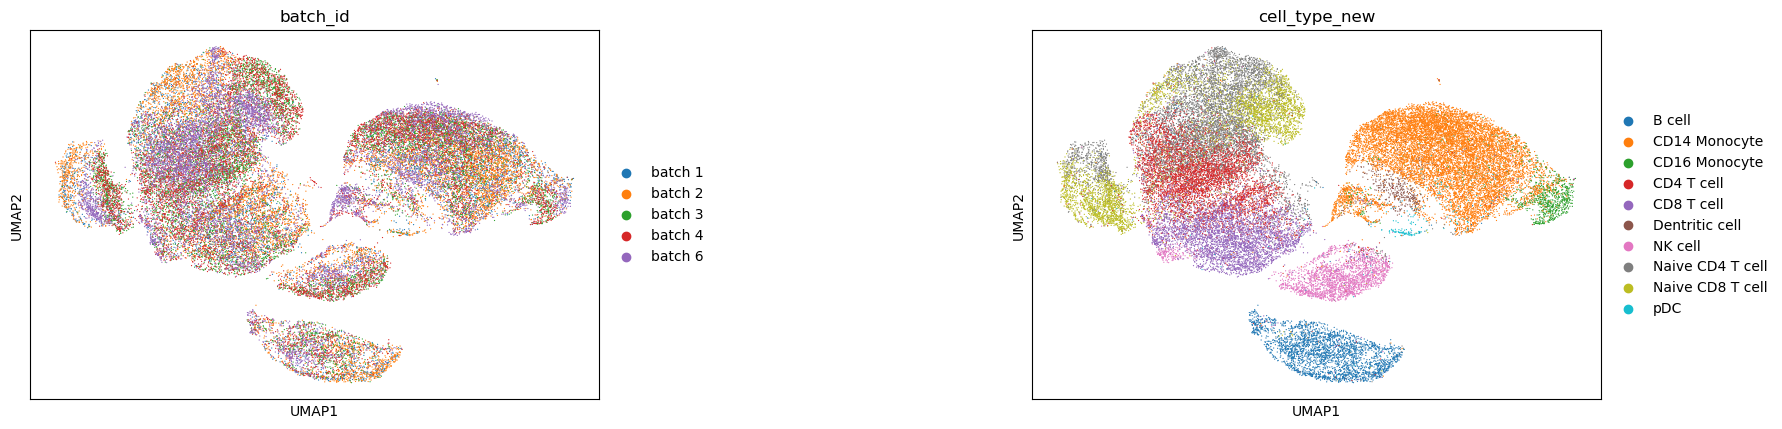

In [10]:
sc.pp.neighbors(genescore_mtx, n_neighbors=10, use_rep='PeakVI')
sc.tl.umap(genescore_mtx)
#sc.tl.leiden(genescore_mtx, resolution=1.5)
sc.pl.umap(genescore_mtx, color=['batch_id','cell_type_new'], ncols=2, wspace=0.6)

### combat

In [75]:
peak_combat = merge_peak.copy()
#sc.pp.combat(peak_combat, key='dataset')

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [76]:
min_cells = int(peak_combat.shape[0] * 0.4)
sc.pp.filter_genes(peak_combat, min_cells=min_cells)

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [77]:
sc.pp.combat(peak_combat, key='dataset')

In [78]:
#sc.pp.normalize_total(peak_combat, target_sum=1e4)
sc.pp.log1p(peak_combat)
#sc.pp.scale(peak_combat, max_value=10)
sc.tl.pca(peak_combat, svd_solver='arpack')

In [79]:
genescore_mtx.obsm['Combat_5'] = peak_combat.obsm['X_pca']

### harmony and seurat

In [122]:
harmony = pd.read_csv("../../data/pbmc_batch/pbmc_large_batch/harmony_peak_5.csv", index_col=0).to_numpy()
genescore_mtx.obsm['harmony_5'] = harmony

In [123]:
seurat = pd.read_csv("../../data/pbmc_batch/pbmc_large_batch/seurat_peak_5.csv", index_col=0).to_numpy()
genescore_mtx.obsm['seurat_5'] = seurat

### trvae

In [14]:
trvae_test = merge_peak.copy()

In [15]:
min_cells = int(trvae_test.shape[0] * 0.3)
sc.pp.filter_genes(trvae_test, min_cells=min_cells)

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [21]:
epi_integration = epk.ml.BridgeVAE(promoter_dt=trvae_test.X.todense(), enhancer_z = np.concatenate((peak_1.obsm['epipack_z_bce'], 
                                                                                                           peak_2.obsm['epipack_z_bce'], 
                                                                                                           peak_3.obsm['epipack_z_bce'],
                                                                                                           peak_4.obsm['epipack_z_bce'],
                                                                                                           peak_5.obsm['epipack_z_bce']
                                                                                                           ), axis=0),
                         batch_id=batch_id, 
                         z_dim=50, batch_size=256, layer_num=2, reg_kl=1e-6, reg_mmd=0.01, reg_rec=1, reg_z_l2=0, use_batch_norm=True, use_layer_norm=False, device='cpu')

- Model initializing...
- [Manually setting]: Model will be initialized in CPU mode.
- Initialization complete...


In [22]:
epi_integration.train_model(nepochs=50, rec_loss='MSE')

Epochs: 100%|██████████| 50/50 [29:25<00:00, 35.31s/it, val_kl_loss=9.92e+5, val_loss_z_dist=1.01, val_mmd=0.0789, val_rec_loss=3.03]


In [23]:
z = epi_integration.get_latent()
genescore_mtx.obsm['trVAE_2'] = z.detach().cpu().numpy()

In [26]:
epi_integration = epk.ml.BridgeVAE(promoter_dt=trvae_test.X.todense(), enhancer_z = np.concatenate((peak_1.obsm['epipack_z_bce'], 
                                                                                                           peak_2.obsm['epipack_z_bce'], 
                                                                                                           peak_3.obsm['epipack_z_bce'],
                                                                                                           peak_4.obsm['epipack_z_bce'],
                                                                                                           peak_5.obsm['epipack_z_bce']
                                                                                                           ), axis=0),
                         batch_id=batch_id, 
                         z_dim=50, batch_size=256, layer_num=2, reg_kl=1e-6, reg_mmd=0.01, reg_rec=1, reg_z_l2=0, use_batch_norm=True, use_layer_norm=False, device='cpu')

epi_integration.train_model(nepochs=50, rec_loss='MSE')

z = epi_integration.get_latent()
genescore_mtx.obsm['trVAE_5'] = z.detach().cpu().numpy()

- Model initializing...
- [Manually setting]: Model will be initialized in CPU mode.
- Initialization complete...


Epochs: 100%|██████████| 50/50 [29:37<00:00, 35.54s/it, val_kl_loss=1.02e+6, val_loss_z_dist=1, val_mmd=0.0748, val_rec_loss=3.04]   


In [27]:
genescore_mtx

AnnData object with n_obs × n_vars = 38853 × 3000
    obs: 'celltype', 'batch_id', 'leiden', 'cell_type_new'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'batch_id_colors', 'cell_type_new_colors', 'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'Combat_1', 'Combat_2', 'Combat_3', 'Combat_4', 'Combat_5', 'LIGER_1', 'LIGER_2', 'LIGER_3', 'LIGER_4', 'LIGER_5', 'PeakVI_1', 'PeakVI_2', 'PeakVI_3', 'PeakVI_4', 'PeakVI_5', 'X_pca', 'X_umap', 'epipack', 'epipack_1', 'epipack_2', 'epipack_3', 'epipack_4', 'epipack_5', 'epipack_w_o_zreg_1', 'epipack_w_o_zreg_2', 'epipack_w_o_zreg_3', 'epipack_w_o_zreg_4', 'epipack_w_o_zreg_5', 'harmony_1', 'harmony_2', 'harmony_3', 'harmony_4', 'harmony_5', 'seurat_1', 'seurat_2', 'seurat_3', 'seurat_4', 'seurat_5', 'trVAE_1', 'trVAE_2', 'trVAE_3', 'trVAE_4', 'trVAE_5'
    varm: 'PCs'
    layers: 'count'
    obsp: 'connectivities', 'distan

### liger

In [87]:
import pyliger

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.


In [88]:
liger_test = merge_peak.copy()

In [89]:
min_cells = int(liger_test.shape[0] * 0.3)
sc.pp.filter_genes(liger_test, min_cells=min_cells)

In [90]:
liger_test

AnnData object with n_obs × n_vars = 38853 × 8994
    obs: 'orig.ident', 'nCount_peaks', 'nFeature_peaks', 'dataset'
    var: 'features', 'n_cells'

In [91]:
batch_list = ['batch 1','batch 2', 'batch 3', 'batch 4', 'batch 6']

In [100]:
bdata = merge_peak.copy()
adata_list = [bdata[bdata.obs.dataset == b].copy() for b in batch_list]

In [101]:
for i, ad in enumerate(adata_list):
    ad.uns["sample_name"] = batch_list[i]
    # Hack to make sure each method uses the same genes
    ad.uns["var_gene_idx"] = np.arange(bdata.n_vars)

In [97]:
#genescore_mtx.write_h5ad("pbmc_large_tmp1002.h5ad")

In [110]:
liger_data = pyliger.create_liger(adata_list, remove_missing=False, make_sparse=False)
# Hack to make sure each method uses the same genes
liger_data.var_genes = bdata.var_names
pyliger.normalize(liger_data)
pyliger.scale_not_center(liger_data)
pyliger.optimize_ALS(liger_data, k=20)
pyliger.quantile_norm(liger_data)

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
100%|██████████| 30/30 [05:15<00:00, 10.52s/it]


In [111]:
genescore_mtx.obsm["LIGER_5"] = np.zeros((genescore_mtx.shape[0], liger_data.adata_list[0].obsm["H_norm"].shape[1]))
for i, b in enumerate(batch_list):
    genescore_mtx.obsm["LIGER_5"][genescore_mtx.obs.batch_id == b] = liger_data.adata_list[i].obsm["H_norm"]

### benchmarking

In [4]:
biocon = scib_metrics.benchmark.BioConservation(isolated_labels=False, nmi_ari_cluster_labels_leiden=True, nmi_ari_cluster_labels_kmeans=False, silhouette_label=True, clisi_knn=False)
batchcor = scib_metrics.benchmark.BatchCorrection(silhouette_batch=True, ilisi_knn=True, kbet_per_label=True, graph_connectivity=False, pcr_comparison=False)

In [5]:
genescore_mtx

AnnData object with n_obs × n_vars = 38853 × 3000
    obs: 'celltype', 'batch_id', 'leiden', 'cell_type_new'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'batch_id_colors', 'cell_type_new_colors', 'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'epipack_mmd_0.5_z_0.01_rep1', 'epipack_mmd_0.5_z_0.01_rep2', 'epipack_mmd_0.5_z_0.01_rep3', 'epipack_mmd_0.5_z_0.01_rep4', 'epipack_mmd_0.5_z_0.01_rep5', 'epipack_mmd_0.5_z_0.05_rep1', 'epipack_mmd_0.5_z_0.05_rep2', 'epipack_mmd_0.5_z_0.05_rep3', 'epipack_mmd_0.5_z_0.05_rep4', 'epipack_mmd_0.5_z_0.05_rep5', 'epipack_mmd_0.5_z_0.1_rep1', 'epipack_mmd_0.5_z_0.1_rep2', 'epipack_mmd_0.5_z_0.1_rep3', 'epipack_mmd_0.5_z_0.1_rep4', 'epipack_mmd_0.5_z_0.1_rep5', 'epipack_mmd_0.5_z_0.5_rep1', 'epipack_mmd_0.5_z_0.5_rep2', 'epipack_mmd_0.5_z_0.5_rep3', 'epipack_mmd_0.5_z_0.5_rep4', 'epipack_mmd_0.5_z_0.5_rep5', 'epipack_mmd_0.5_z_1

In [18]:
bm = Benchmarker(
    genescore_mtx,
    batch_key="batch_id",
    label_key="cell_type_new",
    embedding_obsm_keys=["epipack_mmd_0.5_z_0.01_rep1", "epipack_mmd_0.5_z_0.01_rep2", "epipack_mmd_0.5_z_0.01_rep3", "epipack_mmd_0.5_z_0.01_rep4", "epipack_mmd_0.5_z_0.01_rep5",
                          "epipack_mmd_0.5_z_0.05_rep1", "epipack_mmd_0.5_z_0.05_rep2", "epipack_mmd_0.5_z_0.05_rep3", "epipack_mmd_0.5_z_0.05_rep4", "epipack_mmd_0.5_z_0.05_rep5",
                            "epipack_mmd_0.5_z_0.1_rep1", "epipack_mmd_0.5_z_0.1_rep2", "epipack_mmd_0.5_z_0.1_rep3", "epipack_mmd_0.5_z_0.1_rep4", "epipack_mmd_0.5_z_0.1_rep5",
                            'epipack_mmd_0.5_z_0.5_rep1', 'epipack_mmd_0.5_z_0.5_rep2', 'epipack_mmd_0.5_z_0.5_rep3', 'epipack_mmd_0.5_z_0.5_rep4', 'epipack_mmd_0.5_z_0.5_rep5',
                            'epipack_mmd_0.5_z_1_rep1','epipack_mmd_0.5_z_1_rep2', 'epipack_mmd_0.5_z_1_rep3', 'epipack_mmd_0.5_z_1_rep4', 'epipack_mmd_0.5_z_1_rep5'],
    bio_conservation_metrics=biocon,
    batch_correction_metrics = batchcor,
    n_jobs=4
)

In [19]:
bm.benchmark()

Embeddings: 100%|██████████| 25/25 [53:24<00:00, 128.16s/it]


In [42]:
genescore_mtx.write_h5ad("pbmc_large_final1003.h5ad")

In [4]:
genescore_mtx = sc.read_h5ad("pbmc_large_final1003.h5ad")

In [6]:
genescore_mtx.obsm = None

In [7]:
genescore_mtx

AnnData object with n_obs × n_vars = 38853 × 3000
    obs: 'celltype', 'batch_id', 'leiden', 'cell_type_new'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'batch_id_colors', 'cell_type_new_colors', 'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    varm: 'PCs'
    layers: 'count'
    obsp: 'connectivities', 'distances'

In [15]:
a = pd.DataFrame(genescore_mtx.obsm['Combat_5'])
a.to_csv("../../data/pbmc_batch/pbmc_large_batch/combat_embedding.csv")

In [20]:
genescore_mtx.obsm['PeakVI_1'].shape

(38853, 12)

In [9]:
a = pd.DataFrame(genescore_mtx.obs['cell_type_new'])
a.to_csv("../../data/pbmc_batch/pbmc_large_batch/cell_type_new.csv")

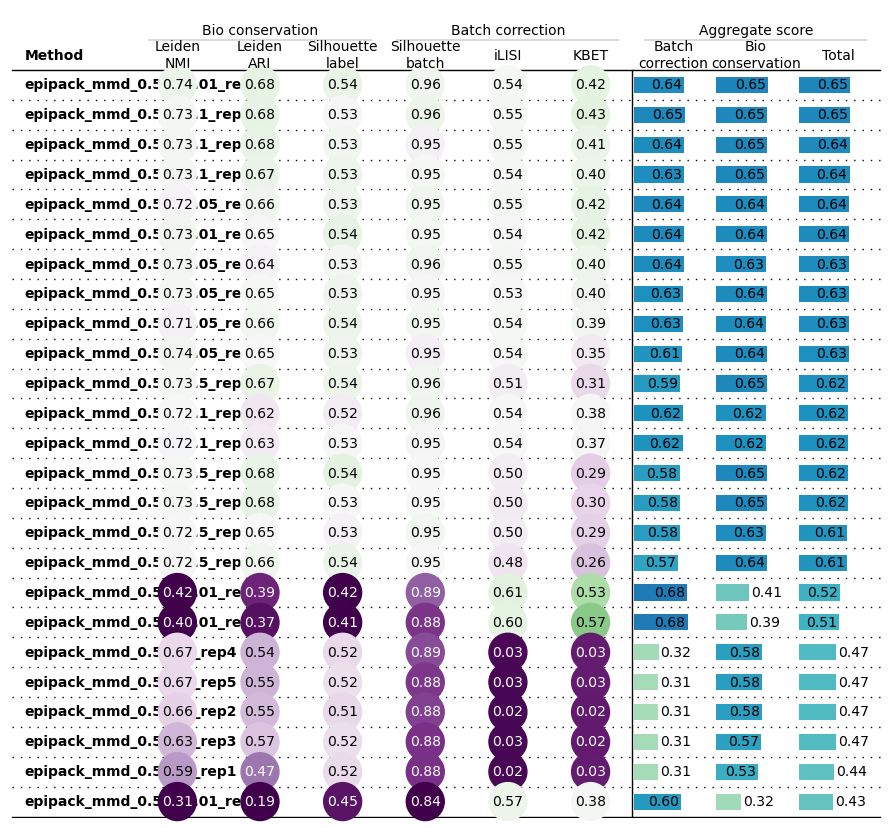

In [20]:
%matplotlib inline
bm.plot_results_table(min_max_scale=False)

In [21]:
df = bm.get_results(min_max_scale=False)

In [22]:
df

,Leiden NMI,Leiden ARI,Silhouette label,Silhouette batch,iLISI,KBET,Batch correction,Bio conservation,Total
Embedding,,,,,,,,,
epipack_mmd_0.5_z_0.01_rep1,0.401159,0.369136,0.409321,0.878848,0.601443,0.567787,0.682693,0.393205,0.509
epipack_mmd_0.5_z_0.01_rep2,0.417518,0.394314,0.420799,0.890386,0.60988,0.527218,0.675828,0.410877,0.516857
epipack_mmd_0.5_z_0.01_rep3,0.744826,0.681634,0.537513,0.955312,0.542984,0.4243,0.640865,0.654658,0.649141
epipack_mmd_0.5_z_0.01_rep4,0.311979,0.190065,0.449196,0.836331,0.570973,0.383772,0.597025,0.31708,0.429058
epipack_mmd_0.5_z_0.01_rep5,0.734967,0.647413,0.539147,0.952318,0.535369,0.423352,0.637013,0.640509,0.639111
epipack_mmd_0.5_z_0.05_rep1,0.729049,0.650936,0.534066,0.95037,0.532241,0.398274,0.626962,0.638017,0.633595
epipack_mmd_0.5_z_0.05_rep2,0.715512,0.663205,0.534341,0.95496,0.553296,0.419547,0.642601,0.637686,0.639652
epipack_mmd_0.5_z_0.05_rep3,0.735101,0.647427,0.534663,0.947259,0.542751,0.347908,0.612639,0.639064,0.628494
epipack_mmd_0.5_z_0.05_rep4,0.727316,0.638348,0.53125,0.955053,0.551542,0.401603,0.636066,0.632305,0.633809


In [23]:
df.to_csv("../../data/pbmc_batch/pbmc_large_batch/mmd_05_pbmc.csv")